In [1]:
from doctest import testfile

import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [30]:
#Variables
BitsArray = [700,700,700, 700, 700, 700, 700]
bits_tx = np.random.randint(0,2, size=BitsArray[0])
SF = 7
SF_Validos = [7, 8, 9, 10, 11, 12]
M = 2**SF
simbolo_tx = coder(bits_tx, SF)
Decodificados = decoder(simbolo_tx, SF)
chirp_tx = waveform_former(simbolo_tx, SF)
chirp_tx_aux = waveform_former(simbolo_tx, SF)[0]
downchirp = (1 / np.sqrt(M)) * np.exp(-1j * 2 * np.pi * np.arange(M)**2 / M)
simbolo_rx = n_tuple_former(chirp_tx, SF)

## CODIFICADOR

In [19]:

def coder(bits, SF):
    #Verificar si SF es valido
    if SF not in SF_Validos:
        raise ValueError("Invalido")
    #Verificar que la cantidad de bits sea multiplo del SF
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

    # Inicialización del vector de símbolos
    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)

    # Implementación de la ecuación (1)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

print(simbolo_tx)

[ 65  27 125  69  88  30  14  70 122  77  69  53  82  90   7  33  10  52
  75  97  89  50 114  47  43  61  58 122  49  25   5  98  92  27 112  81
  34  10 110  23 123  75  23 120 104 117  98  13  48 106  32 114  47  11
  43 107  34  28 111  27 127  77  72  16  92  49  46  98 121  84  62  58
  30   6  70 105  14  29 110  95 117  26   7  88  85  12  10  78  88  27
  91 117  10 118  12  49   6  46  15 116]


###  Ejemplo de codificación usando la Ecuación (1)

#### Datos de entrada:

- bits = [1, 0, 0, 1, 1, 1, 0]
- SF = 7

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que SF = 7.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


####  Resultado esperado:
57


## DECODIFICADOR

In [20]:
def decoder(s, SF):
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    # Por cada símbolo, reconstruir los SF bits
    for simbolo in s:
        for h in range(SF):
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)

    return np.array(bits_recuperados, dtype=int)  # Convertir al final si querés array
print(Decodificados)

[1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1
 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0
 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0
 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0
 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1
 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1
 1 1 0 0 1 0 1 0 1 0 1 1 

### Decodificación manual del símbolo (Ecuación inversa de la codificación)

#### Dato recibido:

- Símbolo codificado: s = 57
- Spreading Factor: SF = 7

Queremos obtener los 7 bits originales que generaron este símbolo.


#### Desarrollo paso a paso:
$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$


$ (57 >> 0) \& 1 = 57 \& 1 \newline$
                    $\begin{aligned} (57 >> 1) \& 1 = 28 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 2) \& 1 = 14 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 3) \& 1 = 7 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 4) \& 1 = 3 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 5) \& 1 = 1 \& 1 \end{aligned}$
                    $\begin{aligned} (57 >> 6) \& 1 = 0 \& 1 \end{aligned}$



In [21]:
def ber(bits_tx,bits_rx):
    return  np.mean(bits_tx != bits_rx)

print(ber(bits_tx,Decodificados))

0.0


### Waveformer Former

In [27]:

def waveform_former(s, SF):
    M = 2 ** SF  # cantidad de muestras por chirp
    chirps = []

    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)

    return np.array(chirps)  # matriz [N x M]

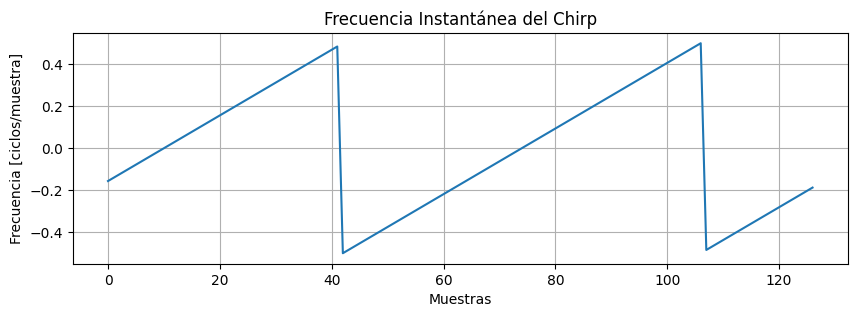

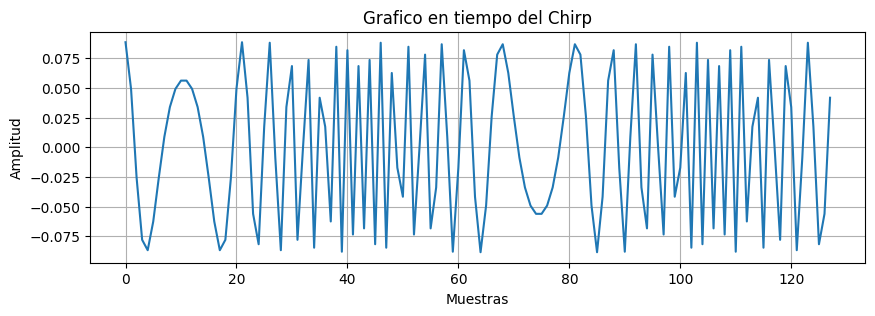

In [34]:
 # Generar un chirp
# Calcular fase y frecuencia instantánea
fase = np.unwrap(np.angle(chirp_tx_aux))
frecuencia_inst = np.diff(fase) / (2 * np.pi)

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(chirp_tx_aux[:2**SF])
plt.title("Grafico en tiempo del Chirp")
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

##  Waveform Former

###  Ecuación (2) del paper de Vangelista

La señal modulada transmitida para un símbolo $\begin{aligned}( s(nT_s) \in \{0, 1, \dots, 2^{SF} - 1\}) \end{aligned}$, según la Ecuación (2) del paper, se define como:



$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$

Donde:
- $\begin{aligned} SF \end{aligned}$: Spreading Factor.
- $\begin{aligned} s(nT_s)\end{aligned}$: símbolo entero codificado (de 0 a \(2^{SF}-1\)).
- $\begin{aligned} k \end{aligned}$: índice de muestra temporal (discreto).
- $\begin{aligned} c(nT_s + kT) \end{aligned}$: muestra compleja de la forma de onda LoRa transmitida.

Esta señal es un "chirp" modulado en frecuencia, cuya frecuencia instantánea varía linealmente.




### n-Tuple Former

In [35]:
def n_tuple_former(received_chirps, SF):
    M = 2 ** SF
    k = np.arange(M)
    downchirp =  np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto) #Es la Transformada Rápida de Fourier (FFT) en NumPy
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)

    return np.array(simbolos_estimados)


##  n-Tuple Former — Receptor Óptimo

###  Descripción Teórica (Sección III del paper de Vangelista)

La detección del símbolo transmitido se realiza aplicando un correlador discreto implementado como un receptor óptimo (n-Tuple Former). El procedimiento consiste en:

1. Multiplicar el chirp recibido por una señal conjugada de referencia conocida como "downchirp":
   $\begin{aligned}
   d(k) = e^{-j2\pi \cdot \frac{k^2}{2^{SF}}}
   \end{aligned}$
2. Aplicar una Transformada Rápida de Fourier (FFT) al producto.
3. Detectar el símbolo como el índice del valor máximo del espectro resultante.


###  Análisis Matemático

Para cada chirp recibido $\begin{aligned} r(k) \end{aligned}$, se realiza:

$\begin{aligned}
d(k) &= r(k) \cdot e^{-j2\pi \cdot \frac{k^2}{2^{SF}}} \\
R(f) &= \text{FFT}\left\{ d(k) \right\} \\
\hat{s} &= \arg \max_{f} \left| R(f) \right|
\end{aligned}$

Donde:
- $\begin{aligned} r(k) \end{aligned}$: chirp recibido de longitud $\begin{aligned} M = 2^{SF} \end{aligned}$
- $\begin{aligned} d(k) \end{aligned}$: señal desmodulada en base al downchirp
- $\begin{aligned} R(f) \end{aligned}$: transformada espectral
- $\begin{aligned} \hat{s} \end{aligned}$: símbolo estimado

Este proceso actúa como un **correlador en frecuencia**, donde cada símbolo posible produce un pico en una posición distinta del espectro. El símbolo transmitido es el que **mejor correlaciona** con el chirp recibido.



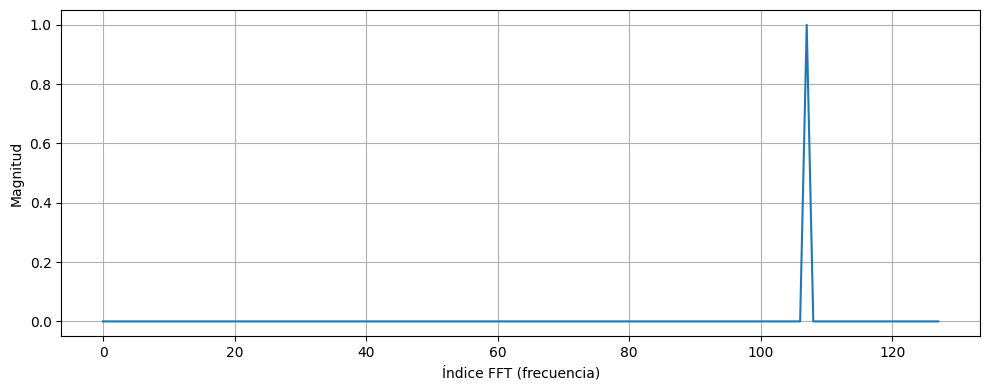

In [36]:
# Producto chirp con downchirp
produc = chirp_tx_aux * downchirp
fft_result = np.fft.fft(produc)
magnitud = np.abs(fft_result)

# Graficar la magnitud de la FFT
plt.figure(figsize=(10, 4))
plt.plot(magnitud)
plt.xlabel("Índice FFT (frecuencia)")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
def ser(s_tx, s_rx):
    return np.mean(s_rx != s_tx)
    #return errores_simbolos(s_tx, s_rx) / len(s_tx)

In [38]:
# Transmisor

# Calcular SER
print("Símbolos transmitidos:", simbolo_tx)
print("Símbolos decodificados:", simbolo_rx)
print("SER:", ser(simbolo_tx, simbolo_rx))

Símbolos transmitidos: [107  32  55 121  90 110 118  23  20  67  87  48  79 113  42  16  57 126
  88  18  71  13 108 113  44  51  79  49  87  49  84  87 121 108  59 122
  59  68  29  47  21  47  50  95  51   3  53  57 107  42 121 113  32  16
 116  55  90  49  39   6  34   4 117  19  58  30  30 117  81  94  33 110
  73  82  13  86  53 110  82  90  72 121  58  44  53  56 115   9  49 114
  71   1  79  55  67   0  71  83  57  12]
Símbolos decodificados: [107  32  55 121  90 110 118  23  20  67  87  48  79 113  42  16  57 126
  88  18  71  13 108 113  44  51  79  49  87  49  84  87 121 108  59 122
  59  68  29  47  21  47  50  95  51   3  53  57 107  42 121 113  32  16
 116  55  90  49  39   6  34   4 117  19  58  30  30 117  81  94  33 110
  73  82  13  86  53 110  82  90  72 121  58  44  53  56 115   9  49 114
  71   1  79  55  67   0  71  83  57  12]
SER: 0.0


### Implementación del ruido AWGN

In [40]:
def agregacion_AWNG(chirp_tx, snr_db):
    # 1. Convertir la SNR de decibeles a escala lineal.
    snr_lineal = 10**(snr_db / 10.0)

    # 2. Calcular la potencia del ruido (N0).
    # Se asume Energía por Símbolo (Es) = 1, según la normalización de la Ecuación (3) del paper.
    #
    potencia_ruido_N0 = 1.0 / snr_lineal

    # 3. Calcular la desviación estándar (sigma) para el ruido.
    # La varianza para cada componente (real e imaginaria) es N0/2.
    sigma = np.sqrt(potencia_ruido_N0 / 2.0)

    # 4. Generar el ruido gaussiano complejo.
    # Se genera ruido para la parte real e imaginaria por separado,
    # con media 0 y desviación estándar sigma.
    ruido_complejo = np.random.normal(0, sigma, size=chirp_tx.shape) +1j * np.random.normal(0, sigma, size=chirp_tx.shape)

    # 5. Sumar el ruido a la señal original y devolverla.
    return chirp_tx + ruido_complejo

##  Canal con Ruido AWGN y Curva BER/SER

### AWGN (Additive White Gaussian Noise)
Según la Sección IV del paper, el sistema puede ser evaluado bajo un modelo de canal con ruido aditivo blanco gaussiano complejo (AWGN).
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: $\begin{aligned} \sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}\end{aligned}$


Donde:

$\begin{aligned}
\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{dB}}{10}}, \quad
\sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.
3. Se decodifica usando n-Tuple Former + FFT.
4. Se comparan los símbolos y bits originales con los decodificados.
5. Se calcula y grafica:
   - BER: tasa de error de bit.
   - SER: tasa de error de símbolo.

Iniciando simulación para Flat FSCM con SF=7...
Simulando para SNR = -11.0 dB...
Simulando para SNR = -10.5 dB...
Simulando para SNR = -10.0 dB...
Simulando para SNR = -9.5 dB...
Simulando para SNR = -9.0 dB...
Simulando para SNR = -8.5 dB...
Simulando para SNR = -8.0 dB...
Simulando para SNR = -7.5 dB...
Simulando para SNR = -7.0 dB...
Simulación completada.
Valores de SNR simulados: [-11.  -10.5 -10.   -9.5  -9.   -8.5  -8.   -7.5  -7. ]
Resultados de BER obtenidos: [1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09, 1e-09]


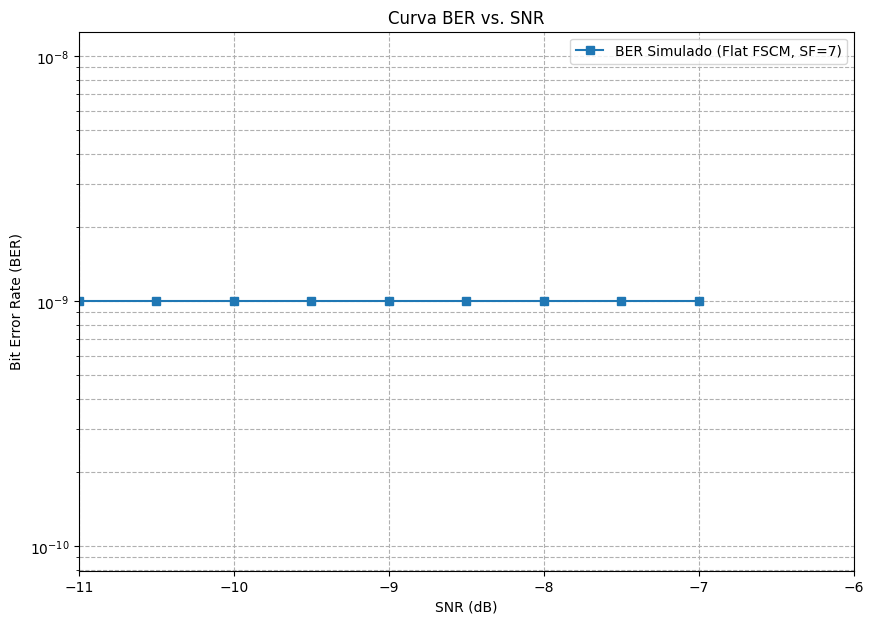

In [48]:
# --- 1. DEFINICIÓN DE PARÁMETROS ---
# Define cuántos bits simular por cada punto de SNR
N_bits_por_punto = 2000 * SF

# CORRECTO: Definir el rango de SNR ANTES de usarlo en el bucle
snr_db_range = np.arange(-11.0, -6.5, 0.5)

# Se crea una lista vacía para almacenar los resultados del BER.
ber_resultados = []


# --- 2. BUCLE DE SIMULACIÓN ---
print(f"Iniciando simulación para Flat FSCM con SF={SF}...")
for snr_db in snr_db_range:

    print(f"Simulando para SNR = {snr_db:.1f} dB...")

    # Realizar una simulación COMPLETA para este SNR
    bits_tx = np.random.randint(0, 2, size=N_bits_por_punto)
    simbolos_tx = coder(bits_tx, SF)
    chirps_tx = waveform_former(simbolos_tx, SF)
    # Asegúrate de que el nombre de tu función de ruido sea el correcto aquí
    #chirps_rx_con_ruido = agregacion_AWNG(chirps_tx, snr_db)
    chirps_rx_con_ruido = chirps_tx
    simbolos_rx = n_tuple_former(chirps_rx_con_ruido, SF)
    bits_rx = decoder(simbolos_rx, SF)
    bits_rx = bits_rx[:len(bits_tx)]

    # Calcular el BER
    current_ber = ber(bits_tx, bits_rx)

    # Prevenir que un BER de 0 se pierda en el gráfico logarítmico
    if current_ber == 0:
        current_ber = 1e-9 # Un valor muy pequeño para que aparezca

    # Añadir (append) el resultado calculado a la lista 'ber_resultados'.
    ber_resultados.append(current_ber)

print("Simulación completada.")
print("Valores de SNR simulados:", snr_db_range)
print("Resultados de BER obtenidos:", ber_resultados)


# --- 3. VISUALIZACIÓN DE RESULTADOS ---
plt.figure(figsize=(10, 7))

# Dibuja la curva usando los resultados que acabas de generar
plt.semilogy(snr_db_range, ber_resultados, 's-', label=f'BER Simulado (Flat FSCM, SF={SF})')

# Añadir etiquetas y formato
plt.title('Curva BER vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
##plt.ylim(1e-5, 1e-1)
plt.xlim(-11, -6)
plt.grid(True, which="both", ls="--")
plt.legend()

# Mostrar el gráfico final
plt.show()

In [126]:
def canal_selectivo_frecuencia(chirps, SF):
    """
    Aplica un canal selectivo en frecuencia a una secuencia de chirps.
    La respuesta del canal tiene un retardo de M muestras (1 símbolo).
    """
    M = 2 ** SF
    # Coeficientes del canal según el paper de Vangelista
    h = np.zeros(M + 1, dtype=complex)
    h[0] = np.sqrt(0.8)
    h[M] = np.sqrt(0.2)

    # Aplanar la matriz de chirps a un solo vector para la convolución
    signal_completa = chirps.flatten()

    # Aplicar el canal mediante convolución
    signal_filtrada = np.convolve(signal_completa, h, mode='full')

    # Reconstruir la matriz de chirps a partir de la señal filtrada
    num_chirps = chirps.shape[0]
    # Se toma solo la parte de la señal filtrada que corresponde a la longitud original
    chirps_out = np.reshape(signal_filtrada[:num_chirps * M], (num_chirps, M))

    return chirps_out

## Canal Selectivo en Frecuencia


En la Sección IV del paper de Vangelista, se modela un canal selectivo en frecuencia mediante una respuesta al impulso discreta definida como:

$\begin{aligned}
h(nT) = \sqrt{0.85} \cdot \delta(nT) + \sqrt{0.2} \cdot \delta(nT - T)
\end{aligned}$

Este canal tiene dos trayectorias:

- Una trayectoria directa con ganancia $\begin{aligned} \sqrt{0.85} \end{aligned}$ y sin retardo.
- Una trayectoria secundaria con ganancia $\begin{aligned} \sqrt{0.2} \end{aligned}$ y un retardo de $\begin{aligned} T \end{aligned}$, es decir, de una duración completa de chirp.

Dado que cada chirp tiene $\begin{aligned} M = 2^{\text{SF}} \end{aligned}$ muestras, se implementa el canal como una convolución discreta entre la señal transmitida y un vector $\begin{aligned} h \end{aligned}$ con dos picos:

$\begin{aligned}
h[n] =
\begin{cases}
\sqrt{0.85}, & n = 0 \\
\sqrt{0.2}, & n = M \\
0, & \text{en otro caso}
\end{cases}
\end{aligned}$

La función canal_selectivo_frecuencia(chirps, SF) realiza lo siguiente:

1. Construye la respuesta impulsiva del canal $\begin{aligned} h[n] \end{aligned}$ como un vector complejo de longitud $\begin{aligned} 2M \end{aligned}$, colocando los valores no nulos en las posiciones $\begin{aligned} 0 \end{aligned}$ y $\begin{aligned} M \end{aligned}$.

2. Concatena los chirps (que originalmente están separados en una matriz) en un único vector 1D con `flatten()`, para simular la transmisión continua por el canal.

3. Aplica la convolución de la señal concatenada con $\begin{aligned} h[n] \), lo que introduce interferencia entre chirps consecutivos debido al retardo.

4. Re-ensambla los chirps desde la señal filtrada, ignorando el primer chirp porque está contaminado por el retardo de la trayectoria secundaria.

5. Devuelve la salida a partir del segundo chirp, ya que es el primero no afectado por el retardo de otro símbolo anterior.

Este modelo permite simular los efectos de dispersión temporal (ISI) característicos de un canal selectivo en frecuencia, y es fundamental para reproducir la curva etiquetada como "Freq. Sel. FSCM" en la Figura 4 del paper de referencia.


Iniciando simulación para Flat FSCM con SF=7...
Simulación completada.


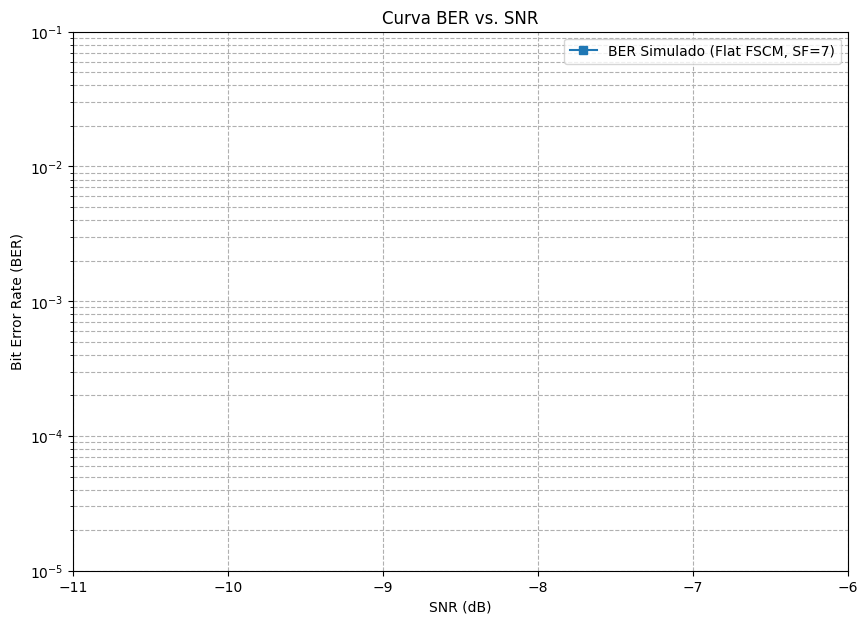

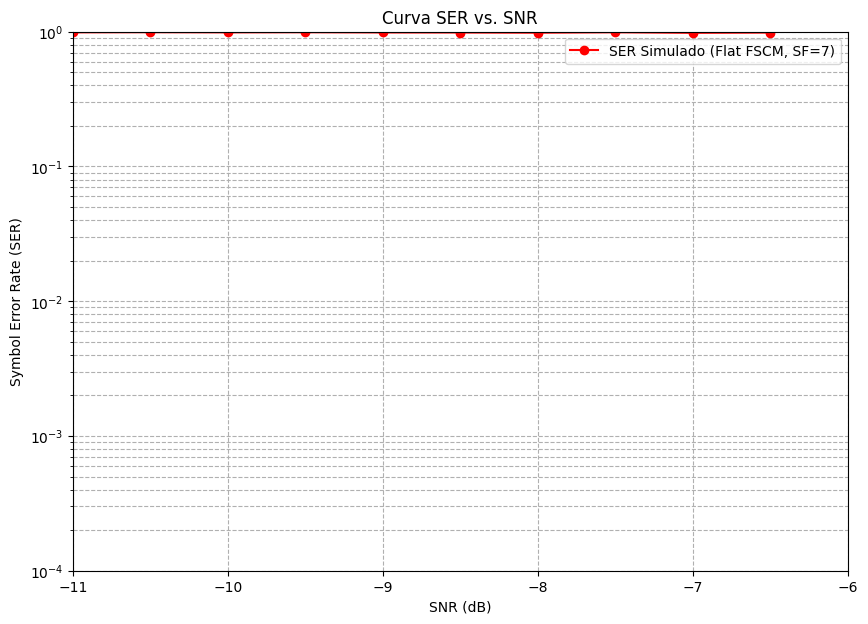

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# DEFINICIÓN DE TODAS LAS FUNCIONES NECESARIAS
# -----------------------------------------------------------------------------

def coder(bits, SF):
    """Codifica bits en símbolos según la Ecuación (1) del paper."""
    if len(bits) % SF != 0:
        relleno = SF - (len(bits) % SF)
        bits = np.concatenate((bits, np.zeros(relleno, dtype=int)))

    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)
    return s

def waveform_former(s, SF):
    """Genera la forma de onda FSCM según la Ecuación (3) del paper."""
    M = 2 ** SF
    chirps = []
    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)
    return np.array(chirps)

def add_awgn(signal_tx, snr_db):
    """Añade ruido AWGN a la señal transmitida (canal)."""
    snr_lineal = 10**(snr_db / 10.0)
    potencia_ruido = 1.0 / snr_lineal
    sigma = np.sqrt(potencia_ruido / 2.0)
    ruido = np.random.normal(0, sigma, size=signal_tx.shape) + \
            1j * np.random.normal(0, sigma, size=signal_tx.shape)
    return signal_tx + ruido

def n_tuple_former(received_chirps, SF):
    """Demodula los símbolos usando el método de la Sección III-A del paper."""
    M = 2 ** SF
    k = np.arange(M)
    downchirp = np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto)
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)
    return np.array(simbolos_estimados)

def decoder(s, SF):
    """Decodifica símbolos a bits (proceso inverso a la Ecuación (1))."""
    bits_recuperados = []
    for simbolo in s:
        for h in range(SF):
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)
    return np.array(bits_recuperados, dtype=int)

def ber(bits_tx, bits_rx):
    """Calcula la Tasa de Error de Bits (Bit Error Rate)."""
    if len(bits_tx) != len(bits_rx):
        raise ValueError(f"Los tamaños de los arrays de bits no coinciden: bits_tx={len(bits_tx)}, bits_rx={len(bits_rx)}")
    return np.mean(bits_tx != bits_rx)

def ser(s_tx, s_rx):
    """Calcula la Tasa de Error de Símbolos (Symbol Error Rate)."""
    if len(s_tx) != len(s_rx):
        raise ValueError(f"Los tamaños de los arrays de símbolos no coinciden: s_tx={len(s_tx)}, s_rx={len(s_rx)}")
    return np.mean(s_rx != s_tx)

# -----------------------------------------------------------------------------
# SCRIPT PRINCIPAL DE SIMULACIÓN Y GRAFICACIÓN
# -----------------------------------------------------------------------------

# --- Parámetros de la simulación (según Sección IV del paper) ---
SF = 7  # Spreading Factor para una cardinalidad de 2^7
M = 2**SF

# Aumentar para curvas más suaves y precisas (a costa de más tiempo)
N_bits_por_punto = 2000 * SF

# Rango de SNR a simular (basado en la Figura 1 del paper)
snr_db_range = np.arange(-11.0, -6.0, 0.5)

# --- Listas para almacenar resultados ---
ber_resultados = []
ser_resultados = []

print(f"Iniciando simulación para Flat FSCM con SF={SF}...")

# --- Bucle de simulación ---
for snr_db in snr_db_range:
    # 1. Generar datos aleatorios
    bits_tx = np.random.randint(0, 2, size=N_bits_por_punto)

    # 2. Transmisor: Coder -> Waveform Former
    simbolos_tx = coder(bits_tx, SF)
    chirps_tx = waveform_former(simbolos_tx, SF)

    # 3. Canal: Añadir ruido AWGN
    chirps_rx_con_ruido = add_awgn(chirps_tx, snr_db)

    # 4. Receptor: N-Tuple Former -> Decoder
    simbolos_rx = n_tuple_former(chirps_rx_con_ruido, SF)
    bits_rx = decoder(simbolos_rx, SF)

    # Asegurar que los arrays de bits tengan la misma longitud para la comparación
    bits_rx = bits_rx[:len(bits_tx)]

    # 5. Calcular métricas de error
    current_ber = ber(bits_tx, bits_rx)
    current_ser = ser(simbolos_tx, simbolos_rx)

    # Evitar BER=0 para que se muestre en el gráfico logarítmico
    if current_ber == 0:
        current_ber = 1e-9

    ber_resultados.append(current_ber)
    ser_resultados.append(current_ser)

print("Simulación completada.")

# --- Visualización de Resultados ---
plt.style.use('default')

# Gráfico de BER
plt.figure(figsize=(10, 7))
plt.semilogy(snr_db_range, ber_resultados, 's-', label=f'BER Simulado (Flat FSCM, SF={SF})')
plt.title('Curva BER vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(1e-5, 1e-1)
plt.xlim(-11, -6)
plt.show()

# Gráfico de SER
plt.figure(figsize=(10, 7))
plt.semilogy(snr_db_range, ser_resultados, 'o-', color='red', label=f'SER Simulado (Flat FSCM, SF={SF})')
plt.title('Curva SER vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(1e-4, 1.0)
plt.xlim(-11, -6)
plt.show()